# Physics-Informed Fitness

## Goal: Show how fitness functions can be customized to enforce problem-specific constraints.

### Pre-Requisites

It is recommended to check out the [symbolic regression tutorial](tutorial_4.html) before continuing.

### Problem Description

A basic physics problem that benefits from using physics-informed fitness is modeling the velocity of an object falling through a viscous liquid. Here we'll model a the velocity of a ball falling through honey. Using Newton's 2nd law ($F = ma \to a = F/m$), we can derive that $a = g - cv/m$ where $g$ is the acceleration due to gravity, $c$ is a drag term, $v$ is the velocity of the ball, and $m$ is the mass of the ball. We can use this fact to enforce that the models Bingo produces for velocity are physically consistent.

**TODO free-body diagram showing problem, note that we are not factoring buoyancy here**

### Creating Training Data

We can integrate $a = g - cv/m$ to get the true equation of the ball's velocity as it falls through a fluid: $\frac{mg}{c} \left(1 - \exp \left(\frac{ct}{m}\right)\right)$. Note that while we can derive the true equation in this case, there are problems where we can't do so and only have training data. So, we will only be using this true equation to generate training data and use GPSR to get a model from the data.

Let's assume our ball has a mass of 1 $kg$ and a radius of 3 $cm$; on Earth $g$ is roughly 9.8 $m/s^2$; and for the ball dropping through honey, $c$ is roughly $1.8 \pi \, kg/s \approx 5.655 \, kg/s$ (Stokes' Law without velocity) at $\text{20}^{\circ}$C.

In [1]:
import numpy as np

m = 1
r = 3.0/100.0
g = 9.8
c = 5.655

t = np.linspace(0, 10, num=100).reshape((-1, 1))
v = m * g / c * (1 - np.exp(c * t / m))

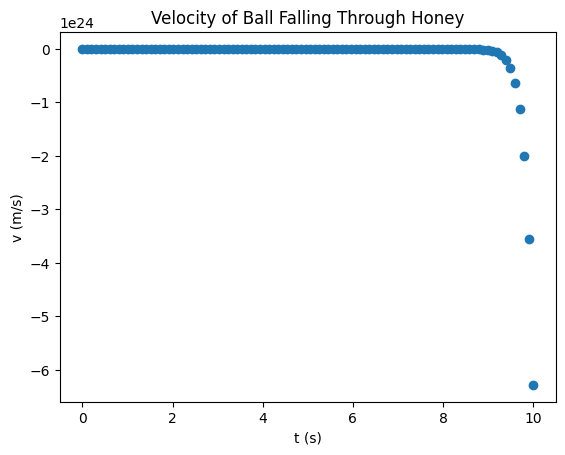

In [2]:
import matplotlib.pyplot as plt

plt.scatter(t, v)
plt.xlabel("t (s)")
plt.ylabel("v (m/s)")
plt.title("Velocity of Ball Falling Through Honey")
plt.show()

### Symbolic Regression Setup

See the [symbolic regression tutorial](tutorial_4.html) for more information.

#### AGraph Component Generator

In [3]:
from bingo.symbolic_regression import ComponentGenerator

component_generator = ComponentGenerator(input_x_dimension=t.shape[1])
component_generator.add_operator("-")
component_generator.add_operator("*")
component_generator.add_operator("/")
component_generator.add_operator("exp")

/home/runner/work/bingo/bingo/bingo/symbolic_regression/__init__.py:31: UserWarning: Could not load C++ modules No module named 'bingocpp.build'
  warnings.warn(f"Could not load C++ modules {import_err}")


#### AGraph Generator

In [4]:
from bingo.symbolic_regression import AGraphGenerator

AGRAPH_SIZE = 10

agraph_generator = AGraphGenerator(agraph_size=AGRAPH_SIZE,
                                   component_generator=component_generator)

#### AGraph Variation

In [5]:
from bingo.symbolic_regression import AGraphCrossover, AGraphMutation

crossover = AGraphCrossover()
mutation = AGraphMutation(component_generator)

#### Evaluation

##### Defining the Custom Fitness Function

Here we're going to create our own fitness function based on the existing `ExplicitRegression` which is used for typical symbolic regression.

In [6]:
from bingo.symbolic_regression import ExplicitRegression

class FallingBallRegression(ExplicitRegression):
    def __init__(self, training_data, mass_of_ball, radius_of_ball,
                 g, drag_term, metric="mae", relative=False):
        super().__init__(training_data, metric, relative)

        self.m = mass_of_ball
        self.r = radius_of_ball
        self.g = g
        self.c = drag_term
        
    def evaluate_fitness_vector(self, individual):
        typical_fitness_vector = super().evaluate_fitness_vector(individual)

        v, dv_dt = individual.evaluate_equation_with_x_gradient_at(
            self.training_data.x)
        v, dv_dt = np.nan_to_num(v.flatten()), np.nan_to_num(dv_dt.flatten())
        derivative_fitness_vector = self.g - self.c * v / self.m - dv_dt

        return typical_fitness_vector + derivative_fitness_vector

In `__init__`, we are defining the same arguments that `ExplicitRegression` needs (`training_data`, `metric`, and `relative`) as well as information specific to our problem (`mass_of_ball`, `radius_of_ball`, `g`, and `drag_term`). Then we are setting up `ExplicitRegression` and storing the physics terms in our object.

In `evaluate_fitness_vector`, we are getting the normal fitness vector using `ExplicitRegression`'s `evaluate_fitness_vector` and adding it with a physics-informed `derivative_fitness_vector`. The `derivative_fitness_vector` penalizes the individual if its velocity predictions do not abide by the known $a = \frac{dv}{dt} = g - \frac{cv}{m}$. We can do this by using `AGraph`'s `evaluate_equation_with_x_gradient_at` which will normally give us $y$, $dy/dx$, but in our case $x=t$ and $y=v$, so we get $v$, $dv/dt$.

##### Using the Custom Fitness Function in Evaluation

Let's instantiate and wrap our custom fitness function with `ContinuousLocalOptimization` to allow for local optimization of `AGraph` constants.

In [7]:
from bingo.symbolic_regression import ExplicitTrainingData
from bingo.local_optimizers.scipy_optimizer import ScipyOptimizer
from bingo.local_optimizers.local_opt_fitness import LocalOptFitnessFunction
training_data = ExplicitTrainingData(t, v)

fitness = FallingBallRegression(training_data=training_data, mass_of_ball=m,
                                radius_of_ball=r, g=g, drag_term=c)
optimizer = ScipyOptimizer(fitness, method='lm')
local_opt_fitness = LocalOptFitnessFunction(fitness, optimizer)

We can then use the fitness function in `Evaluation`.

In [8]:
from bingo.evaluation.evaluation import Evaluation

evaluator = Evaluation(local_opt_fitness)

#### Evolutionary Algorithm

In [9]:
from bingo.evolutionary_algorithms.age_fitness import AgeFitnessEA

POPULATION_SIZE = 50
MUTATION_PROB = 0.1
CROSSOVER_PROB = 0.4

ea = AgeFitnessEA(evaluator, agraph_generator, crossover, mutation,
                  CROSSOVER_PROB, MUTATION_PROB, POPULATION_SIZE)

#### Pareto Front

In [10]:
from bingo.stats.pareto_front import ParetoFront

def agraph_similarity(ag_1, ag_2):
    """a similarity metric between agraphs"""
    return ag_1.fitness == ag_2.fitness and ag_1.get_complexity() == ag_2.get_complexity()

pareto_front = ParetoFront(secondary_key=lambda ag: ag.get_complexity(),
                           similarity_function=agraph_similarity) 

#### Evolutionary Optimizer

In [11]:
from bingo.evolutionary_optimizers.island import Island

island = Island(ea, agraph_generator, POPULATION_SIZE, hall_of_fame=pareto_front)

### Running Symbolic Regression

Now we can run symbolic regression on our training data to produce a model.

In [12]:
import random

MAX_GENS = 1000
ERR_THRESHOLD = 0.001

np.random.seed(0)
random.seed(0)
island.evolve_until_convergence(MAX_GENS, ERR_THRESHOLD)

/tmp/ipykernel_5412/3026084833.py:19: RuntimeWarning: overflow encountered in multiply
  derivative_fitness_vector = self.g - self.c * v / self.m - dv_dt
/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:144: RuntimeWarning: overflow encountered in exp
  return np.exp(forward_eval[param1])
/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:95: RuntimeWarning: overflow encountered in multiply
  reverse_eval[param2] -= reverse_eval[reverse_index] *\
/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:83: RuntimeWarning: overflow encountered in multiply
  reverse_eval[param1] += reverse_eval[reverse_index]*forward_eval[param2]
/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:84: RuntimeWarning: overflow encountered in multiply
  reverse_eval[param2] += reverse_eval[reverse_index]*forward_eval[param

/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:78: RuntimeWarning: overflow encountered in multiply
  return forward_eval[param1] * forward_eval[param2]
/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:149: RuntimeWarning: overflow encountered in multiply
  reverse_eval[param1] += reverse_eval[reverse_index] *\


/opt/hostedtoolcache/Python/3.12.7/x64/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:499: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:95: RuntimeWarning: overflow encountered in divide
  reverse_eval[param2] -= reverse_eval[reverse_index] *\


/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:78: RuntimeWarning: overflow encountered in scalar multiply
  return forward_eval[param1] * forward_eval[param2]
/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:149: RuntimeWarning: overflow encountered in scalar multiply
  reverse_eval[param1] += reverse_eval[reverse_index] *\


/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:89: RuntimeWarning: overflow encountered in divide
  return forward_eval[param1] / forward_eval[param2]
/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:94: RuntimeWarning: overflow encountered in divide
  reverse_eval[param1] += reverse_eval[reverse_index] / forward_eval[param2]
/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:83: RuntimeWarning: overflow encountered in scalar multiply
  reverse_eval[param1] += reverse_eval[reverse_index]*forward_eval[param2]


/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:84: RuntimeWarning: overflow encountered in add
  reverse_eval[param2] += reverse_eval[reverse_index]*forward_eval[param1]


/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:95: RuntimeWarning: overflow encountered in scalar divide
  reverse_eval[param2] -= reverse_eval[reverse_index] *\
/home/runner/work/bingo/bingo/bingo/symbolic_regression/agraph/evaluation_backend/operator_eval.py:95: RuntimeWarning: overflow encountered in scalar multiply
  reverse_eval[param2] -= reverse_eval[reverse_index] *\


OptimizeResult(success=False, status=2, message='The maximum number of generational steps (1000) occurred', ngen=1000, fitness=np.float64(1.2215426198686914e+22), time=12.79496, ea_diagnostics=EaDiagnosticsSummary(beneficial_crossover_rate=np.float64(0.008869179600886918), detrimental_crossover_rate=np.float64(0.40964523281596454), beneficial_mutation_rate=np.float64(0.04033898305084746), detrimental_mutation_rate=np.float64(0.54), beneficial_crossover_mutation_rate=np.float64(0.009538152610441768), detrimental_crossover_mutation_rate=np.float64(0.4678714859437751)))

### Results

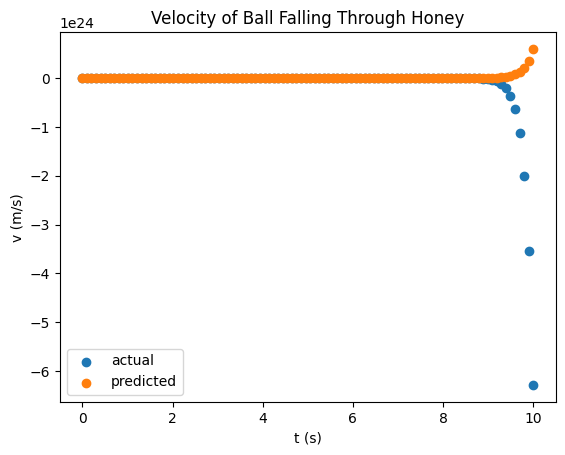

In [13]:
best_individual = pareto_front[0]
pred_v = best_individual.evaluate_equation_at(t)

plt.scatter(t, v)
plt.scatter(t, pred_v)
plt.xlabel("t (s)")
plt.ylabel("v (m/s)")
plt.legend(["actual", "predicted"])
plt.title("Velocity of Ball Falling Through Honey")
plt.show()